# Phase 1 : Project kickoff :  first OCR Test

### what is OCR ?
Optical Character Recognistsion (OCR) is the process of converting images of text (printed or handwritten) into actual digital text that a computer can read and process
we will use:
- OpenCV for image loading and processing
- pytesseract (wrapper for Goole's Tesseract engine) for extracting text from images

##### 1.import libraries

In [11]:
import cv2
import pytesseract
# Set the tesseract command path
pytesseract.pytesseract.tesseract_cmd = r"C:\Users\Maria\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline

##### 2.download a sample images for testing

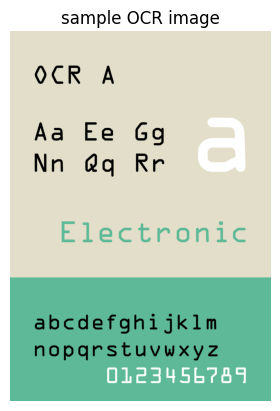

In [6]:
import requests
from io import BytesIO
# let's download an image from the web 
url="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Typeface_specimen_OCR_A.svg/1200px-Typeface_specimen_OCR_A.svg.png"
response = requests.get(url)
image= Image.open(BytesIO(response.content)).convert("RGB")

# display it 
plt.imshow(image)
plt.axis("off")
plt.title("sample OCR image")
plt.show()

##### 3. extract text using pytesseract

In [13]:
# convert image to a format OpenCV understands
image_cv = np.array(image)
image_cv=cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR) # OpenCV is used to prepare the image for pytesseract
#run OCR 
extracted_text = pytesseract.image_to_string(image_cv) # extract text from image
print("extracted text:  ")
print(extracted_text)

extracted text:  
OCR A

Aa Ee Gg
Nn @q Kr

abcdefghijklm
nopqrstuvwxyz



- not all the texts were detected
- only text in black was detected


##### 4. show OCR bounding boxes
this let us see where the text was detected and it is helpful later for:
  
      - cleaning data
      - improving recognition
      - training detection models

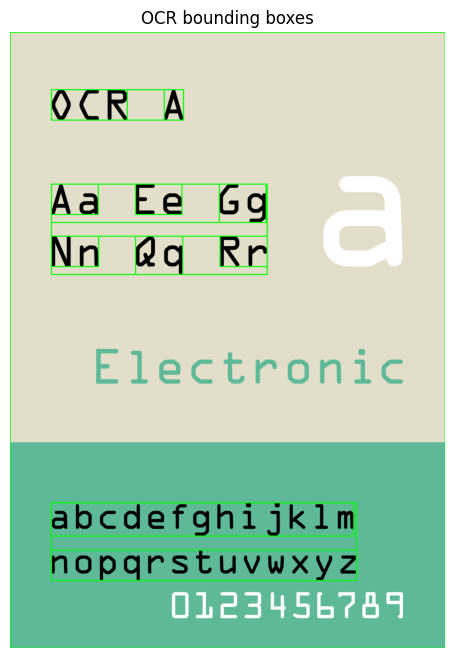

In [16]:
# get OCR data with bounding boxes
ocr_data = pytesseract.image_to_data(image_cv, output_type=pytesseract.Output.DICT)
# draw boxes on image
n_boxes =len(ocr_data['level'])
for i in range (n_boxes):
    (x,y,w,h) = (ocr_data['left'][i], ocr_data['top'][i],ocr_data['width'][i], ocr_data['height'][i])
    cv2.rectangle(image_cv,(x,y),(x+w,y+h),(0,255,0),2)

#convert back to RGB and display
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(image_cv,cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("OCR bounding boxes")
plt.show()


tesseract and most OCR engines work best with high contrast , which mean that:
- black text on white background = easy to detect
- white or light-clored text on a light or complex background = hard to detect
- colored text can confuse the system if the contrast is low
  
that's because:

- tesseract internally binarizes the image (turn it black and white ) before detecting text
- if the colored text doesn't stand out clearly in that binarized image it will be missed

!!! this can be fixed by preprocessing the image to make text of any color more visible using techniques like:
* grayscale conversion ==>
convert the image to grayscale to reduce noise from color

 ``` python
gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
```
* adaptive thresholding ==> this binarize the image better when lighting or colors vary
  ``` python
  thresh = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 11, 2)```

 
* inversion trick ==> if the text is white on dark we can try inverting the image
 ```python
inverted = cv2.bitwise_not(gray)
 ```
* color masking ==> if we are targeting a specific color , we can isolate them using HSV color masking befor OCR 

#### let's make a pipeline to test each method and compare its results

In [34]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set tesseract path
pytesseract.pytesseract.tesseract_cmd = r"C:\Users\Maria\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"

def read_image(path):
    return cv2.imread(path)

def show_image(title, img):
    plt.figure(figsize=(8,6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def run_ocr(img):
    return pytesseract.image_to_string(img)

# 1. Grayscale
def preprocess_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Adaptive Threshold
def preprocess_adaptive_threshold(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

# 3. Inverted Grayscale
def preprocess_inverted(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.bitwise_not(gray)

# 4. Color Masking (e.g., green text)
def preprocess_color_mask(img, color='green'):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if color == 'green':
        # Adjust bounds as needed
        lower = np.array([40, 40, 40])
        upper = np.array([80, 255, 255])
    elif color == 'white':
        lower = np.array([0, 0, 200])
        upper = np.array([180, 25, 255])
    else:
        raise ValueError("Unsupported color")
    
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(img, img, mask=mask)
    return cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

def read_image_from_url(url):
    response = requests.get(url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    return image

# --- Run all in one
def test_all_methods(img_path):
    img = read_image_from_url(img_path)
    
    methods = {
        "Grayscale": preprocess_grayscale,
        "Adaptive Threshold": preprocess_adaptive_threshold,
        "Inverted Grayscale": preprocess_inverted,
        "Color Masking (Green)": lambda x: preprocess_color_mask(x, 'green'),
        "Color Masking (White)": lambda x: preprocess_color_mask(x, 'white'),
    }

    for name, method in methods.items():
        print(f"\n--- {name} ---")
        processed = method(img)
        show_image(name, processed)
        text = run_ocr(processed)
        print(text)





--- Grayscale ---


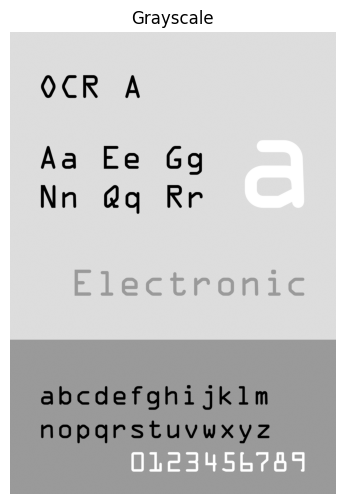

OCR A

Aa Ee Gg
Nn @q Rr

Electronic

O1e345b784


--- Adaptive Threshold ---


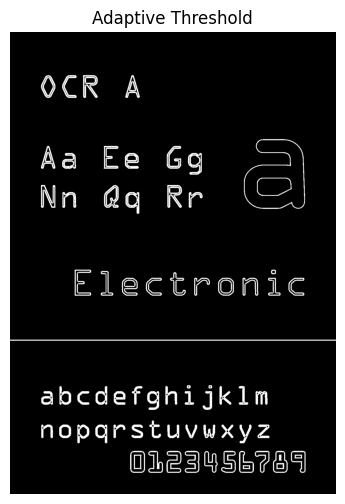

OCR A

Aa Ee Gog a

Nn @q Kr
Electronic

abcdefghijklm
nopaqrstuvwxyz

Obes9SE? OF


--- Inverted Grayscale ---


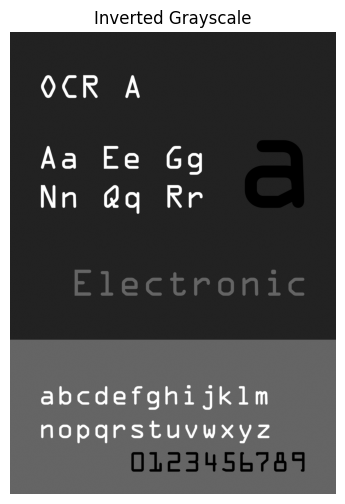

OCR A

Aa Ee Gg
Nn @q Rr

Electronic

O1e345b784


--- Color Masking (Green) ---


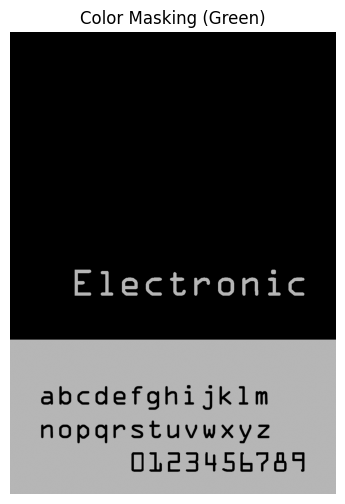

Electronic

abcdefghijklm

nopqrstuvwxyz
OL2345b6734



--- Color Masking (White) ---


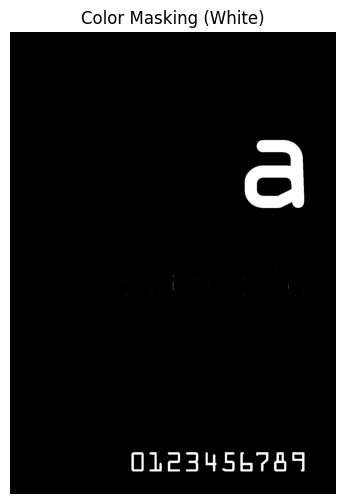

ObeS45b744



In [35]:
# let's call it with our image
test_all_methods("https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Typeface_specimen_OCR_A.svg/1200px-Typeface_specimen_OCR_A.svg.png"
)

##### result analysis:
- grayscale:
  - detected most of the black white and green text
  - missed some white and black text
- adaptive threshold:
  - captured more than grayscale
  - slight noise : characters like "Gog" instead of "Gg" and "Obes9SE? OF"
- inverted grayscale:
  - detected all colors text
  - slight noise
  - all numbers are detect wrong
- color masking green
  - detect green text perfectly
  - missed black and white
- color masking white
  - detected most of the white text but wrong
  - missed all other colors
    